In [1]:
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import time
from tqdm import tqdm
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
TRAINING_IMAGE_FOLDER = "/Users/archismanchakraborti/Desktop/Final_model/archive/DIV2k/train_hr"
VALID_IMAGE_FOLDER = "/Users/archismanchakraborti/Desktop/Final_model/archive/DIV2k/valid_hr"

HIGH_RES_TRAIN_FOLDER = "/Users/archismanchakraborti/Desktop/Final_model/archive/processed_data/high_res_train"
LOW_RES_TRAIN_FOLDER = "/Users/archismanchakraborti/Desktop/Final_model/archive/processed_data/low_res_train"
HIGH_RES_VALID_FOLDER = "/Users/archismanchakraborti/Desktop/Final_model/archive/processed_data/high_res_valid"
LOW_RES_VALID_FOLDER = "/Users/archismanchakraborti/Desktop/Final_model/archive/processed_data/low_res_valid"

In [3]:
class Preprocessor:
    def __init__(self, image_folder, high_res_base_folder, low_res_base_folder) -> None:
        self.image_folder = image_folder
        self.high_res_base_folder = high_res_base_folder
        self.low_res_base_folder = low_res_base_folder
        self.high_res_img_counter, self.low_res_img_counter = 0, 0

        self.images = os.listdir(image_folder)
        os.makedirs(high_res_base_folder, exist_ok = True)
        os.makedirs(low_res_base_folder, exist_ok = True)

    
    def break_into_patches(self, img, patch_size = 33, stride = 14):
        """ Breaks an image into patches of size patch_size x patch_size 
        with a stride of stride pixels 
        Args:
            img: np.array of shape (H, W, C)
            patch_size: int, size of the patch
            stride: int, stride of the patch
        Returns:
            np.array of shape (N, patch_size, patch_size, C)
        """
        patches = []
        for i in range(0, img.shape[0] - patch_size + 1, stride):
            for j in range(0, img.shape[1] - patch_size + 1, stride):
                patch = img[i:i+patch_size, j:j+patch_size]
                patches.append(patch)
        return np.array(patches)
    
    def save_patches(self, patches, base_path, high_res = True):
        """ Saves patches to a directory
        Args:
            patches: np.array of shape (N, patch_size, patch_size, C)
            base_path: str, path to the directory
            high_res: bool, if True, saves the patches to the high_res folder
        """               
        if high_res: 
            for patch in patches:
                cv2.imwrite(os.path.join(base_path, f"{self.high_res_img_counter}.jpg"), patch)
                self.high_res_img_counter += 1
        else: 
            for patch in patches:
                cv2.imwrite(os.path.join(base_path, f"{self.low_res_img_counter}.jpg"), patch)
                self.low_res_img_counter += 1
                
    def blur_image(self, image, scaling_factor: int = 4):
        """Blurr Image by (1) applying Gaussian Blur, (2) Subsample from 
        image buy the scaling factor, (3) Upsample with bicubic interpolation
        Args:
            image (np.ndarray): Image of dimensions (H, W, C)
            scaling factor (int): Scaling factor of the images.
        Returns:
            The low resolution image"""
        # Randomly select Gaussian blur parameters
        kernel_size = np.random.choice([3, 5, 7, 9, 11])
        sigmaX = np.random.uniform(0.1, 10)
        sigmaY = np.random.uniform(0.1, 10)
        
        # Apply Gaussian blur
        blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigmaX, sigmaY)

        # Subsample the image by the scaling factor
        width = int(blurred_image.shape[1] / scaling_factor)
        height = int(blurred_image.shape[0] / scaling_factor)
        subsampled_image = cv2.resize(blurred_image, (width, height), interpolation=cv2.INTER_AREA)

        # Upscale the subsampled image by the same factor using bicubic interpolation
        upscaled_image = cv2.resize(subsampled_image, (blurred_image.shape[1], blurred_image.shape[0]), interpolation=cv2.INTER_CUBIC)

        return upscaled_image
    
    def make_low_res_patches(self, high_res_patches):
        """ Makes low resolution patches from high resolution patches
        Args:
            high_res_patches: np.array of shape (N, patch_size, patch_size, C)
        Returns:
            np.array of shape (N, patch_size, patch_size, C)
        """
        low_res_patches = np.zeros_like(high_res_patches)
        for i, patch in enumerate(high_res_patches):
            low_res_patches[i] = self.blur_image(patch)
        return low_res_patches
    
    def preprocess_images(self):
        """ Saves all patches to the respective directories
        image_folder (filepath): Path where the base images are collected from
        high_res_base_folder (filepath): Path where the high res sub-images are saved
        low_res_base_folder (filepath): Path where the low res sub-images are saved.
        """
        for image in tqdm(self.images, desc="Processing images"):
            if image.endswith((".png", ".jpg")):
                img = cv2.imread(os.path.join(self.image_folder, image))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                high_res_patches = self.break_into_patches(img, patch_size=128, stride = 256)
                low_res_patches = self.make_low_res_patches(high_res_patches=high_res_patches)
                self.save_patches(high_res_patches, self.high_res_base_folder, high_res=True)
                self.save_patches(low_res_patches, self.low_res_base_folder, high_res=False)
            else:
                continue

In [4]:
train_preprocessor = Preprocessor(image_folder=TRAINING_IMAGE_FOLDER, 
                                 high_res_base_folder=HIGH_RES_TRAIN_FOLDER, 
                                 low_res_base_folder=LOW_RES_TRAIN_FOLDER)
valid_preprocessor = Preprocessor(image_folder=VALID_IMAGE_FOLDER, 
                                 high_res_base_folder=HIGH_RES_VALID_FOLDER, 
                                 low_res_base_folder=LOW_RES_VALID_FOLDER)
# train_preprocessor.preprocess_images()
# valid_preprocessor.preprocess_images()

In [5]:
class PairedImageDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, transform=None):
        """Initialize the dataset class
        Args:
            hr_dir(str): Path to the high resolution directory
            lr_dir(str): Path to the low resolution directory
            transform: Transformations to apply. By default applies the ToTensor operation"""
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.hr_images = sorted(os.listdir(hr_dir))
        self.lr_images = sorted(os.listdir(lr_dir))
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),])
        else: self.transform = transform 

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_image_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr_image_path = os.path.join(self.lr_dir, self.lr_images[idx])

        hr_image = Image.open(hr_image_path).convert("RGB")
        lr_image = Image.open(lr_image_path).convert("RGB")

        if self.transform:
            hr_image = self.transform(hr_image)
            lr_image = self.transform(lr_image)

        return hr_image, lr_image

In [6]:
train_dataset = PairedImageDataset(HIGH_RES_TRAIN_FOLDER, LOW_RES_TRAIN_FOLDER)
valid_dataset = PairedImageDataset(HIGH_RES_VALID_FOLDER, LOW_RES_VALID_FOLDER)

BATCH_SIZE: int = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, use_activation: bool, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=True)
        self.activation = nn.LeakyReLU(0.2, inplace=True) if use_activation else nn.Identity()

    def forward(self, x):
        return self.activation(self.conv(x))
    

class DenseResidualBlock(nn.Module):
    def __init__(self, in_channels: int, channels = 32, beta: float = 0.2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.beta = beta 
        self.conv = nn.ModuleList()

        for block_no in range(5):
            self.conv.append(ConvBlock(in_channels + channels * block_no, 
                                       channels if block_no < 4 else in_channels,
                                         use_activation=True if block_no < 4 else False,
                                           kernel_size=3, stride=1, padding=1))
            
            
    def forward(self, x):
        new_inputs = x
        for block in self.conv:
            out = block(new_inputs)
            new_inputs = torch.cat([new_inputs, out], dim=1)
        return self.beta * out + x
    

class RRDB(nn.Module):
    def __init__(self, in_channels, residual_beta, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.residual_beta = residual_beta
        self.rrdb = nn.Sequential(*[DenseResidualBlock(in_channels, beta=residual_beta) for _ in range(3)])

    def forward(self, x):
        return self.rrdb(x) * self.residual_beta + x
    

class ModifiedSRCNN(nn.Module):
    def __init__(self, in_channels: int, num_blocks: int, 
                 n1: int, n2: int, f1: int, f2: int, f3: int,
                 *args, **kwargs) -> None:
        """ Initialize the SRCNN with Dense Residual network model with the required layers 
         Below params are the hyperparameters for the SRCNN model without the 
         Bassic block which has been added extra other than the resisual connections.
        in_channels (int): Input number of channels
        num_blocks (int): Number of RRDB blocks
        n1 (int): Number of filters in the first convolutional layer
        n2 (int): Number of filters in the second convolutional layer
        f1 (int): Kernel size of the first convolutional layer
        f2 (int): Kernel size of the second convolutional layer
        f3 (int): Kernel size of the third convolutional layer
        residual_beta (float): Residual connection weight
        """
        super().__init__(*args, **kwargs)
        self.conv1 = ConvBlock(in_channels, n1, kernel_size=f1, stride=1, padding=4, use_activation=True)
        self.blocks = nn.Sequential(*[RRDB(n1, residual_beta=0.5) for _ in range(num_blocks)])
        self.conv2 = ConvBlock(n1, n2, kernel_size=f2, stride=1, padding=2, use_activation=True)
        self.conv3 = ConvBlock(n2 + in_channels, in_channels, kernel_size=f3, stride=1, padding=2, use_activation=False)

    def forward(self, x):
        initial = x 
        x = self.conv1(x)
        x = self.blocks(x)
        x = self.conv2(x)
        x = torch.concat([x, initial], dim=1)
        x = self.conv3(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

In [8]:
model = ModifiedSRCNN(in_channels = 3, num_blocks = 3, n1 = 64, n2 = 32, f1 = 9, f2 = 5, f3 = 5)
LEARNING_RATE = 0.001
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, log_folder, patience=5):
    # Move model to the specified device
    model.to(device)
    
    # Create directories for storing artifacts
    os.makedirs(log_folder, exist_ok=True)
    
    log_file = os.path.join(log_folder, 'logs.log')
    best_weights_file = os.path.join(log_folder, 'best_weights.pth')
    
    best_loss = float('inf')
    patience_counter = 0
    
    with open(log_file, 'w') as log:
        log.write('Epoch,Train Loss,Val Loss,Epoch Time\n')
        
        for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
            start_time = time.time()
            
            # Training phase
            model.train()
            train_losses = []
            for hr_images, lr_images in train_loader:
                hr_images, lr_images = hr_images.to(device), lr_images.to(device)
                optimizer.zero_grad()
                sr_images = model(lr_images)
                loss = criterion(sr_images, hr_images)
                loss.backward()
                optimizer.step()
                
                train_losses.append(loss.item())
            
            train_loss = np.mean(train_losses)
            
            # Validation phase
            model.eval()
            val_losses = []
            with torch.no_grad():
                for hr_images, lr_images in val_loader:
                    hr_images, lr_images = hr_images.to(device), lr_images.to(device)
                    sr_images = model(lr_images)
                    loss = criterion(sr_images, hr_images)
                    val_losses.append(loss.item())
            
            val_loss = np.mean(val_losses)
            
            epoch_time = time.time() - start_time
            
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch Time: {epoch_time:.2f}s')
            log.write(f'{epoch+1},{train_loss},{val_loss},{epoch_time}\n')
            
            # Check for best validation loss
            if val_loss < best_loss:
                best_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), best_weights_file)
            else:
                patience_counter += 1
                        
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    return model

In [10]:
NUM_EPOCHS: int = 100
PATIENCE: int = 15
# model = train_model(model=model, 
#                         train_loader=train_loader, 
#                         val_loader=valid_loader, 
#                         criterion=criterion, 
#                         optimizer=optimizer, 
#                         num_epochs=NUM_EPOCHS, 
#                         device=DEVICE,
#                         log_folder="logs/SRCNN", 
#                         patience=PATIENCE)

In [11]:
state_dict = torch.load("/Users/archismanchakraborti/Desktop/Final_model/weights/srcnn_weights.pth", map_location=DEVICE)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
batch = next(iter(valid_loader))
hrs, lrs = batch

with torch.no_grad():
    srs = model(lrs.to(DEVICE)).detach().cpu()

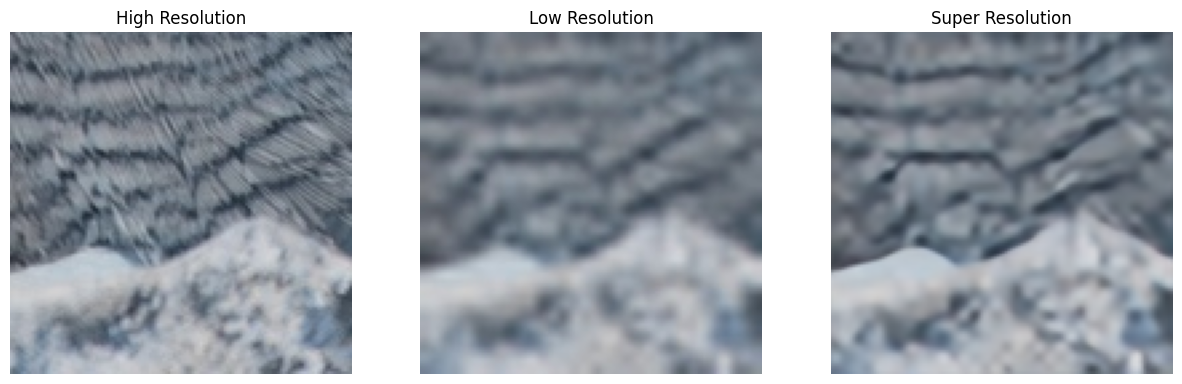

In [15]:
IMAGE_NUM = 4
hr_image = hrs[IMAGE_NUM].permute(1, 2, 0).numpy()
lr_image = lrs[IMAGE_NUM].permute(1, 2, 0).numpy()
sr_image = srs[IMAGE_NUM].permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(hr_image)
ax[0].set_title('High Resolution')
ax[0].axis('off')
ax[1].imshow(lr_image)
ax[1].set_title('Low Resolution')
ax[1].axis('off')
ax[2].imshow(sr_image)
ax[2].set_title('Super Resolution')
ax[2].axis('off')
plt.show()